# Prediction of Foraging States of *P. pacificus*

This notebook will guide you through the prediction pipeline for foraging behaviours in *Pristionchus pacificus*.<br>
You will already need to have data that was extracted by PharaGlow.<br>

The single steps of this pipeline are the following:
1. additional feature calculation
2. model and augmentation loading
3. data augmentation as defined by AugmentSelect file
4. prediction
5. visualisation

In [1]:
import os
import time
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import logging

#from sklearn.preprocessing import LabelEncoder

import json
import joblib
from sklearn.impute import SimpleImputer

#home = os.path.expanduser("~")
sys.path.append(os.getcwd())
from functions.load_model import load_tolist
import functions.visualise as vis
import functions.process as proc
from functions.io import setup_logger, makedir
from functions import FeatureEngine#, build_model

Please provide where your files are stored and where you would like your data to be saved in the following section.

In [2]:
datestr = time.strftime("%Y%m%d-%HH%MM")
home = os.path.expanduser("~")
inpath = os.path.abspath(f"./testset/")
outpath = makedir(os.path.abspath(f"./test_output/")) # you can also use datestr to specify the outpath folder, like this makedir(os.path.abspath(f"{datestr}_PpaPrediction"))

In the following section, standard model parameters are set. Change those only if necessary.

In [3]:
version = '1-0'
model_path = os.path.abspath(f"./model/ForagingPredictionModel_{version}.pickle")
ASpath = os.path.abspath(f"./model/AugmentSelect_{version}.pickle")    
smooth = 30*3


logger_out = os.path.join(outpath,f"{datestr}_PpaForagingPrediction.log")
logger = setup_logger('logger',filename=logger_out)
logger.info(f"Foraging prediction of Pristionchus pacificus")
logger.info(f"Version of model == {version}, stored at {model_path}")
logger.info(f"Files to be predicted stored at {inpath}")

INFO:logger:Foraging prediction of Pristionchus pacificus
INFO:logger:Version of model == 1-0, stored at /gpfs/soma_fs/home/boeger/PpaForagingPrediction/model/ForagingPredictionModel_1-0.pickle
INFO:logger:Files to be predicted stored at /gpfs/soma_fs/home/boeger/PpaForagingPrediction/testset


## 1. Feature Engineering
In the following section, additional features are calculated.

In [4]:
in_engine = FeatureEngine.run(inpath, outpath, logger)

INFO:logger:
feature calculation for GGE0136_c_results_7.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([3391, 3392, 3393]),)


/gpfs/soma_fs/home/boeger/PpaForagingPrediction/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)


## 2. Load Model and Augmentation
Here only the model- and augmentation-files are loaded

In [5]:
model = joblib.load(model_path)
augsel = joblib.load(ASpath)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

/gpfs/soma_fs/home/boeger/usr/miniconda3/envs/PpaPred/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.1.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/gpfs/soma_fs/home/boeger/usr/miniconda3/envs/PpaPred/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator PCA from version 1.1.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/gpfs/soma_fs/home/boeger/usr/miniconda3/envs/PpaPred/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator FunctionTransformer from 

In [6]:
augsel

Pipeline(steps=[('add_history',
                 FunctionTransformer(func=<function addhistory at 0x2b88919c2e80>,
                                     kw_args={'dt_shifted': [5, 10, 15]})),
                ('select_features',
                 FunctionTransformer(func=<function select_features at 0x2b88919c32e0>,
                                     kw_args={'names': 'all'}))])

In [7]:
model

Pipeline(memory='/gpfs/soma_fs/scratch/src/boeger',
         steps=[('minmax_scaler', MinMaxScaler()),
                ('PCA', PCA(n_components=143)),
                ('XGB',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.09162614263668575,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.01888083311618756, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=85,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=1910, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', predictor=None, ...))])

## 3. & 4. Perform Data Augmentation & Prediction
The augmented data files are saved under the specified outpath/subfolder.<br>
(with subfolder being the inpath folder name postfixed by _engine)

In [8]:
data = load_tolist(in_engine, droplabelcol=False)

GGE0136_c_results_7.json_labeldata.csv


In [9]:
y_pred = []
y_proba = []
X_augm = []
y_pred_smooth = []

for X in data:
    X = augsel.fit_transform(X)
    col = X.columns
    X = imp.fit_transform(X)
    proba = model.predict_proba(X)
    proba_smooth = pd.DataFrame(proba).rolling(30, min_periods=1, center=True).mean().values
    pred = np.argmax(proba_smooth, axis=1)
    pred_smooth = proc.ffill_bfill(pred, smooth)
    pred_smooth = np.nan_to_num(pred_smooth,-1)
    
    y_pred.append(pred)
    y_proba.append(proba)
    y_pred_smooth.append(pred_smooth)
    X_augm.append(pd.DataFrame(X, columns=col))

## 4. Prediction
The augmented + predicted data files are saved under the specified outpath/subfolder.<br>
(with subfolder being the inpath folder name postfixed by _predicted)<br>

In the _predicted, plots of the bouts predicted over time along with the velocity and pumping rate are saved as pdf files.

In [10]:
grouped_col = {#0:'#blue',
                -1:'black',
                1:'violet',2:'limegreen',3:'gold', 4: 'dodgerblue', 7:"cyan", 8:'darkgreen',9:'lightcoral',
                0:'#89278f', # feeding
                6: '#e76f51', 5:'deeppink' #biting, 
              }

numtoname = {-1:'None', 0:'p. feeding', 1: '1', 2:'2', 3:'3', 4:'4', 5:'p. biting', 6:'p.biting', 7:'7', 8: '8', 9:'9'}

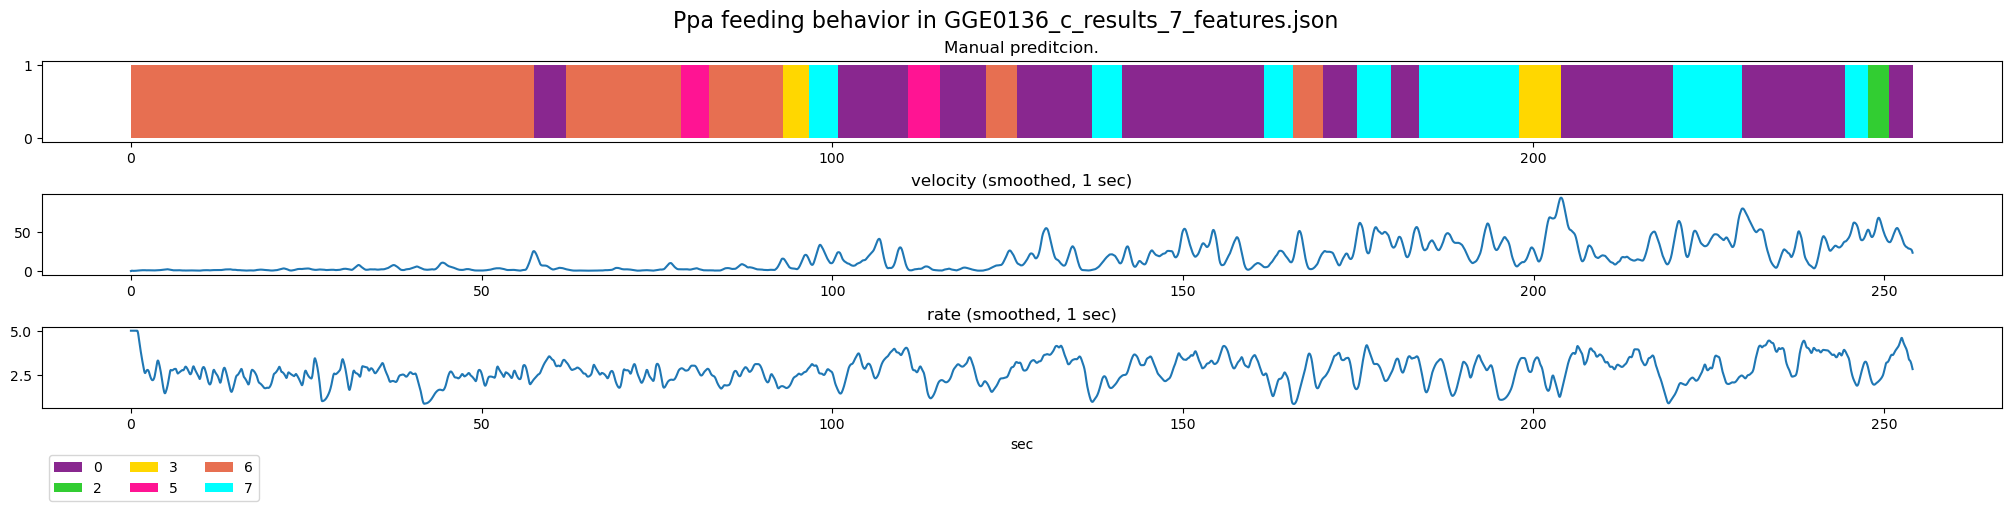

In [11]:
for y_ps, d, fn in zip(y_pred_smooth, data, in_engine):
    out_generic, out_specific = os.path.split(os.path.split(in_engine[fn])[0])
    out_specific = "_".join([out_specific.split("_")[0], 'predicted'])
    out = makedir(os.path.join(out_generic, out_specific))
    fn = os.path.basename(in_engine[fn])
    out_fn = '_'.join(fn.split('_')[:4]+['predicted.json'])
    p_out = pd.concat([d, pd.DataFrame(y_ps, columns=['prediction'])], axis=1)
    jsnL = json.loads(p_out.to_json(orient="split"))
    jsnF = json.dumps(jsnL, indent = 4)
    with open(os.path.join(out,out_fn), "w") as outfile:
        outfile.write(jsnF)
        
    
    onoff = proc.onoff_dict(y_ps, labels =np.unique(y_ps))
    timeinsec = np.array(range(len(d)))/30
    fig, axs = plt.subplots(3,1, figsize=(20,5),constrained_layout=True)

    for c in np.unique(y_ps).astype(int):
        axs[0].broken_barh(onoff[c],(0,1),facecolors = grouped_col[c])
    axs[0].set_xticks(range(len(timeinsec))[::100*30])
    axs[0].set_xticklabels(timeinsec[::100*30].astype(int))
    axs[0].set_title('Manual preditcion.')
    for i,c in enumerate(['velocity', 'rate']):
        axs[i+1].plot(timeinsec,d[c].rolling(30, min_periods=0).mean())
        axs[i+1].set_title(f"{c} (smoothed, 1 sec)")
    axs[2].set_xlabel('sec')

    plt.legend(handles=[Patch(facecolor=grouped_col[i]) for i in np.unique(y_ps).astype(int)],
          labels=[key for key in numtoname if key in np.unique(y_ps)],
          ncol=3, loc='upper left',
          bbox_to_anchor=(0, -0.5))
    fig.suptitle(f'Ppa feeding behavior in {fn}',fontsize=16)
    plt.savefig(os.path.join(out, '_'.join(fn.split('_')[:4]+['predictedbouts.pdf'])))
    plt.show()